# 1.0 Introduction

In this notebook we will analyze the relationship between technical and educational features with compensation level of data scientists’ professionals. As we are already doing along other notebooks from this project, we will be using data from the 2020 Stack Overflow Survey.

All the imports used here are commonly distributed into a standard conda installation. A requirements.txt and pipfile files are available in the root of the repository. Either of those can be used for the installation of the required packages and their specified version for the correct execution of this project notebooks.

This notebook is divided into three parts. First there is this introduction with declared imports and data loading and filtering. Next, in the second part we do some descriptive analysis regarding compensation, educational and technological variables. Then, in the last part, we try three different methods to measure the relationship between compensation and the selected variables.



## 1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(context='notebook', style='whitegrid', font_scale=1)

## 1.2 Loading Data

Loading the data from the 2020 survey, setting `Respodent` id to be the index of the data frame. Removing missing observations of `ConvertedComp` (compensations converted to yearly U.S. dollars) and `DevType` (declared of type of developer, such as, back-end, front-end, full-stack, data scientists, etc.). Then selecting only those developers of the type **Data scientists or machine learning specialist**.

In [2]:
# loadig 2020 survey data
data_folder = 'data'
file_path = os.path.join(data_folder, '2020_data.zip')
df = pd.read_csv(file_path, index_col='Respondent')
df.shape

(64461, 60)

In [3]:
# removing missing data from selected variables and also selecting data scientists
df.dropna(subset=['ConvertedComp', 'DevType'], inplace=True)
ds = df['DevType'].str.contains('Data scientist or machine learning specialist')
ds_df = df[ds].copy()
ds_df.shape

(2619, 60)

# 2.0 Descriptive Analysis

## 2.1 Compensations

In our dataset we have two variables that can be used to measure professionals' compensations: `CompTotal` and `ConvertedComp`. Taking a look at some statistics from both variables, it can be seen that `CompTotal` has a much greater standard deviation. This is a result from the usage of different currencies to measure compensations (depending on the country) as well as different frequency in which the compensation is paid. `ConvertedComp` solve these problems by annualizing the `CompTotal` and converting it to US$. 

Since it is a more standardized variable, `ConvertedComp` will be used instead of `CompTotal`. Additionaly `ConvertedComp` will be divided by 12 so we can have a monthly compensation measure.

In [4]:
ds_df[['CompTotal', 'ConvertedComp']].describe().round(2)

,CompTotal,ConvertedComp
count,2.619000e+03,2619.00
mean,3.818251e+146,123911.18
std,1.954035e+148,279460.18
min,0.000000e+00,0.00
25%,2.650000e+04,25902.00
50%,7.000000e+04,58000.00
75%,1.500000e+05,104806.50
max,1.000000e+150,2000000.00


In [5]:
# selecting ConvertedComp divded by 12 as our dependent variable(12)
y = ds_df['ConvertedComp'].div(12)

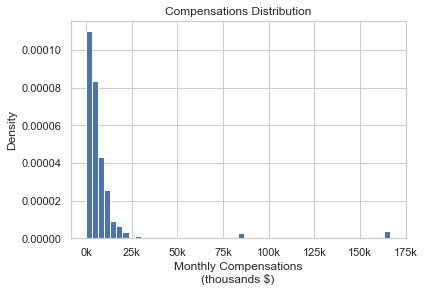

In [6]:
# plotting the monthly ConvertedComp distribution
ax = y.hist(bins=50, density=True)
# formating the x axis
ax.xaxis.set_major_formatter(lambda x, p: f'{x/1000:.0f}k')
# adding labels and titles
plt.xlabel('Monthly Compensations\n(thousands $)')
plt.ylabel('Density')
plt.title('Compensations Distribution')
plt.show()

In [7]:
round((y < 25000).mean() * 100, 2)

94.23

The `ConvertedComp` has a very skewed distribution. Most respondents (94.19%) earn less than 25 thousand dollars per month. With a log transformation we can reduce the skewness of the distribution. This transformation will also make it easier to find linear relationship with other variables, our main purpose in this notebook. But before making this transformation we need to exclude observations with 0 (log of 0 is undertermined).

In [8]:
# number of values that are equal to 0
(y == 0).sum()

18

In [9]:
# removing the values that are equal to 0
y.drop(y[y == 0].index, inplace=True)
# determining a new Series LogConvertedComp
log_y = y.apply(np.log).rename('LogConvertedComp')

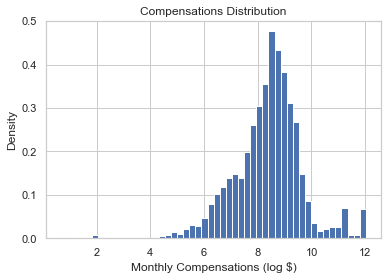

In [10]:
# plotting the distribution of LogConvertedComp
log_y.hist(bins=50, density=True)
plt.xlabel('Monthly Compensations (log $)')
plt.ylabel('Density')
plt.title('Compensations Distribution')
plt.show()

## 2.2 Technological and Educational Data

Next, we will analyze the distributions of our categorical variables related to technological and educational aspects of the respondents. First, we will declare two functions that will **one hot encode** all our selected variables and group then into a dataframe. To do it we will be using `pd.get_dummies` function from the `pandas` package.

Some of those categorical variables can have more than one option selected as an respondent answer. If we applied `pd.get_dummies` directly to those answers we would get as the number of features all the unique cobinations of options (considering only the technological variables we would have 3.683 features). In order to correctly transform our categorical variables first we need to separate the answers by their selected options. Then, from those seperated options we transform then into dummies and finally group those dummies by respondent ID. Those procedures are implemented through the `dummify_col` function.

In [11]:
# selecting the technological columns data 
tech_types = ['Language', 'Platform', 'MiscTech', 'Database']
tech_vars = [tech + 'WorkedWith' for tech in tech_types]
tech_df = ds_df[tech_vars]
tech_df.head()

,LanguageWorkedWith,PlatformWorkedWith,MiscTechWorkedWith,DatabaseWorkedWith
Respondent,,,,
36,C#;Go;HTML/CSS;Java;JavaScript;Python;R;SQL,MacOS;Windows,Node.js;Pandas,IBM DB2;Microsoft SQL Server;MongoDB;SQLite
47,Bash/Shell/PowerShell;C#;Java;JavaScript;Pytho...,Arduino;AWS;Linux;Microsoft Azure;Raspberry Pi,.NET;.NET Core,Microsoft SQL Server;Oracle;PostgreSQL;SQLite
69,HTML/CSS;Python,Linux;Microsoft Azure,Keras;Pandas;TensorFlow,MongoDB
125,Python;SQL,Docker,Keras;Pandas;TensorFlow,PostgreSQL
147,HTML/CSS;JavaScript;Python;TypeScript,NaN,Node.js;Pandas,MariaDB


In [12]:
# viewing the number of unique categories
nunique_tech = tech_df.nunique()
print(f'Sum of unique combination of technological features:', nunique_tech.sum())
nunique_tech

Sum of unique combination of technological features: 3683


LanguageWorkedWith    1415
PlatformWorkedWith     991
MiscTechWorkedWith     634
DatabaseWorkedWith     643
dtype: int64

In [13]:
# selecting the educational variables data
edu_vars = ['EdLevel', 'UndergradMajor']
edu_df = ds_df[edu_vars]
edu_df.head()

,EdLevel,UndergradMajor
Respondent,,
36,Some college/university study without earning ...,"Computer science, computer engineering, or sof..."
47,"Other doctoral degree (Ph.D., Ed.D., etc.)","A natural science (such as biology, chemistry,..."
69,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Computer science, computer engineering, or sof..."
125,"Other doctoral degree (Ph.D., Ed.D., etc.)",NaN
147,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Another engineering discipline (such as civil,..."


In [14]:
# viewing its unique categories
edu_df.nunique()

EdLevel            9
UndergradMajor    12
dtype: int64

In [15]:
def dummify_col(col, thereshold=0):
    """Transform a categorical column into multiple dummy variables
    It was made in a way that it can transform into dummies even variables
    that can have multiple categories into a single observation, suposing that
    categories are seperated by ';'.
    """
    
    # separating multiple categories and expanding it into a single series
    exploded_col = col.dropna().str.split(';').explode()
    # computing the dummies and aggregating into the original dimension of
    # the dataframe (minus missing obs)
    dummies_df = (pd.get_dummies(exploded_col, prefix=col.name).
                  reset_index().groupby('Respondent').max())
    
    # optional procedure of removing missing categories (columns)
    # with a share of response below certain thereshold
    selected_cat = dummies_df.columns[dummies_df.mean() > thereshold]
    selected_dummies_df = dummies_df[selected_cat]
    
    return selected_dummies_df

In [16]:
def dummify_df(df):
    """Apply the dumify function to all the columns of the df
    It is expected the df contains only categorical variables
    All the dummies are then joined into a single dataframe with
    the same indexes as the original dataframe. By maintaining
    the same indexes we can identify the missing variables.
    """
    
    # initiatin a empty dataframe with the same index as the original
    result = pd.DataFrame(index=df.index)
    # interating over selected categorical columns to
    # apply the dumify_col function and join the result to the
    # new dataframe.
    for col in df.columns:
        col_dummies = dummify_col(df[col])
        result = result.join(col_dummies)
    
    result.fillna(0, inplace=True)
        
    return result

In [17]:
def split_var_option(df, col, is_tech):
    """Used to turn the column with the name of the dummy variable into two other columns
    One column with the name of the variable name and another column with the name of the option.
    Used to tidy the data for ploting the comparison of options separated from the variable name.
    The name of the column is given by the col variable.
    Depending on if is_tech or not the ordering of the variable column changes.
    """
    
    df[["var", "option"]] = df[col].str.split('_', expand=True)
    if is_tech:
        df['var'] = df['var'].str.replace('WorkedWith', '')
        var_order = ['Language', 'Platform', 'MiscTech', 'Database']
    else:
        var_order = ['EdLevel', 'UndergradMajor']
    df['var'] = pd.Categorical(df['var'], categories=var_order, ordered=True)
    df.drop(columns=[col], inplace=True)
    
    return df

In [18]:
def generate_distributions(dummy_df, is_tech):
    """Generate the distribution of options and variables based on
    a dataframe with dummy variables.
    """
    
    dummy_dist = dummy_df.mean().sort_values().reset_index()
    dummy_dist.rename(columns={0:'value'}, inplace=True)
    dummy_dist = split_var_option(dummy_dist, "index", is_tech)
    
    return dummy_dist

In [19]:
def display_value(data, option_list):
    """ Just a helper function to display the value
    of a specific category
    """
    indexed_data = data.set_index('option')['value']
    for option in option_list:
        value = indexed_data.loc[option]
        print(f'{option}: {value:.2%}')

In [20]:
def plot_dummies_results(result, is_tech, title):
    """Used to plot comparitive results of option (dummies) for categorical
    variables. Appliable, as long as the dataframe is standardized in a way
    that the it contains at least three columns:
      - var: the name representig the variable that originates the dummies variables
      - option: the option in the variable that is one-hot encoded
      - value: the numeric stat that is being measured
    Depending if the result is from a tech or not (is_tech) the plot configuration changes
    Finally, the plot is added a title.
    """
    
    # palette color selection
    plot_palette = sns.color_palette()
    tech_palette = plot_palette[0:4]
    educ_palette = plot_palette[4:6]
    palette = tech_palette if is_tech else educ_palette
    
    # setting other parameters depending on is_tech
    col_wrap = 2 if is_tech else 1
    aspect = 1.2 if is_tech else 3
    height = 7 if is_tech else 5
    
    # creating a facet grid
    gs = sns.FacetGrid(result, col="var", hue="var", sharey=False,
                       col_wrap=col_wrap, aspect=aspect, height=height,
                       palette=palette)
    # setting the plot as horizontal bar of the options against the values 
    gs.map(plt.barh, 'option', 'value')
    # tidying the facet titles
    gs.set_titles('{col_name}')
    
    # adjusting axis and labels
    for i, ax in enumerate(gs.axes.flat):
        ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
        ax.set_ylabel('')
        ax.set_xlabel('')
    
    # adding the title
    gs.fig.subplots_adjust(top=0.92) # necessary in order to make space for inserting a figure title
    gs.fig.suptitle(title, fontsize=20) # inserting the fig title
    
    plt.show()

### 2.3.1 Technological Atributes

We used variables related to technologies that the respondents worked with in 2020: `LanguageWorkedWith`, `PlatformWorkedWith`, `MiscTechWorkedWith` and `DatabaseWorkedWith`. By one hot encoding those variables we got 74 dummy features. `LanguageWorkedWith` was the question that generated the highest number of features (25). To match the same observations in the `ConvertedComp` variable we reindexed the resulting dummy dataframe.

In [21]:
# creating a data frame of tech dummies
tech_dummies = dummify_df(tech_df).reindex(y.index)
tech_dummies.shape

(2601, 74)

In [22]:
# creating the distribution of tech options
tech_dist = generate_distributions(tech_dummies, True)
tech_dist.head()

,value,var,option
0,0.016148,Database,Couchbase
1,0.017301,MiscTech,Chef
2,0.019608,MiscTech,Puppet
3,0.022684,MiscTech,Unreal Engine
4,0.023068,Language,Dart


In [23]:
# geting the number of unique features and unique features by tech type
unique_techs = tech_dist.reset_index().groupby('var')['option'].nunique()
print(f'Total unique features: {unique_techs.sum()}')
unique_techs

Total unique features: 74


var
Language    25
Platform    16
MiscTech    19
Database    14
Name: option, dtype: int64

In [24]:
selected_languages = ['Python', 'SQL', 'JavaScript', 'R']
display_value(tech_dist, selected_languages)

Python: 82.28%
SQL: 60.67%
JavaScript: 48.21%
R: 29.83%


In [25]:
selected_miscs = ["TensorFlow", "Torch/PyTorch", "Keras", "Apache Spark",
                  "Hadoop", "Pandas", "React Native", "Xamarin", "Node.js"]
display_value(tech_dist, selected_miscs)

TensorFlow: 39.52%
Torch/PyTorch: 20.72%
Keras: 28.14%
Apache Spark: 17.11%
Hadoop: 13.88%
Pandas: 53.02%
React Native: 6.54%
Xamarin: 2.96%
Node.js: 24.80%


In [26]:
selected_db = ["MySQL", "PostgreSQL", "SQLite", "MongoDB"]
display_value(tech_dist, selected_db)

MySQL: 43.75%
PostgreSQL: 42.87%
SQLite: 32.87%
MongoDB: 25.68%


From the distribution of those features, Python seems to be the prefered language for data science, as the majority of developers used that language in their work (82.28%). Another popular language for data science, R, was used by only 29.83% respondents, less than half of Python users. The second language most used is SQL (60.67%), a database language. JavaScript was in the third place (48.21%) and is used for developing websites.

At the platform level we have Linux as being the most preferred operation system (67.74%). Windows comes second with 49.21% of the data scientists Next we have two other platforms technologies that are related to cloud computing and deployment of data science applications: Docker (45.02%) and AWS (35.72%). MacOS comes in fith place with 25.80% of the respondents.

The miscellaneous technologies comprises a set of more specific technologies targeting, for example: machine learning ([TensorFlow](https://en.wikipedia.org/wiki/TensorFlow) (39.52%), [Torch/PyTorch](https://en.wikipedia.org/wiki/PyTorch) (20.72%) and [Keras](https://keras.io/)) (28.14%) big data ([Apache Spark](https://spark.apache.org/) (17.11%) and [Hadoop](https://hadoop.apache.org/)) (13.88%), data wrangling ([Pandas](https://pandas.pydata.org/)) (53.02%). There are also other kinds of technologies that are not commonly used in a data science project, such as [Xamarin](https://dotnet.microsoft.com/apps/xamarin) (2.96%)  and [React Native](https://reactnative.dev/) (6.54%) for the development of mobile apps, and [Node.js](https://nodejs.org/en/) (24.80%) for the development of web apps.

As viewd in the last notebook there isn't much specic technologies at the database layer. The technologies here are some of the most common in the industry. The three most used are comon SQL tech: MySQL (43.75%), PostgreeSQL (42.87%) and SQLite (32.87%). The no-SQL database technology highest ranked is MongoDB (25.68%) comming in fith place.

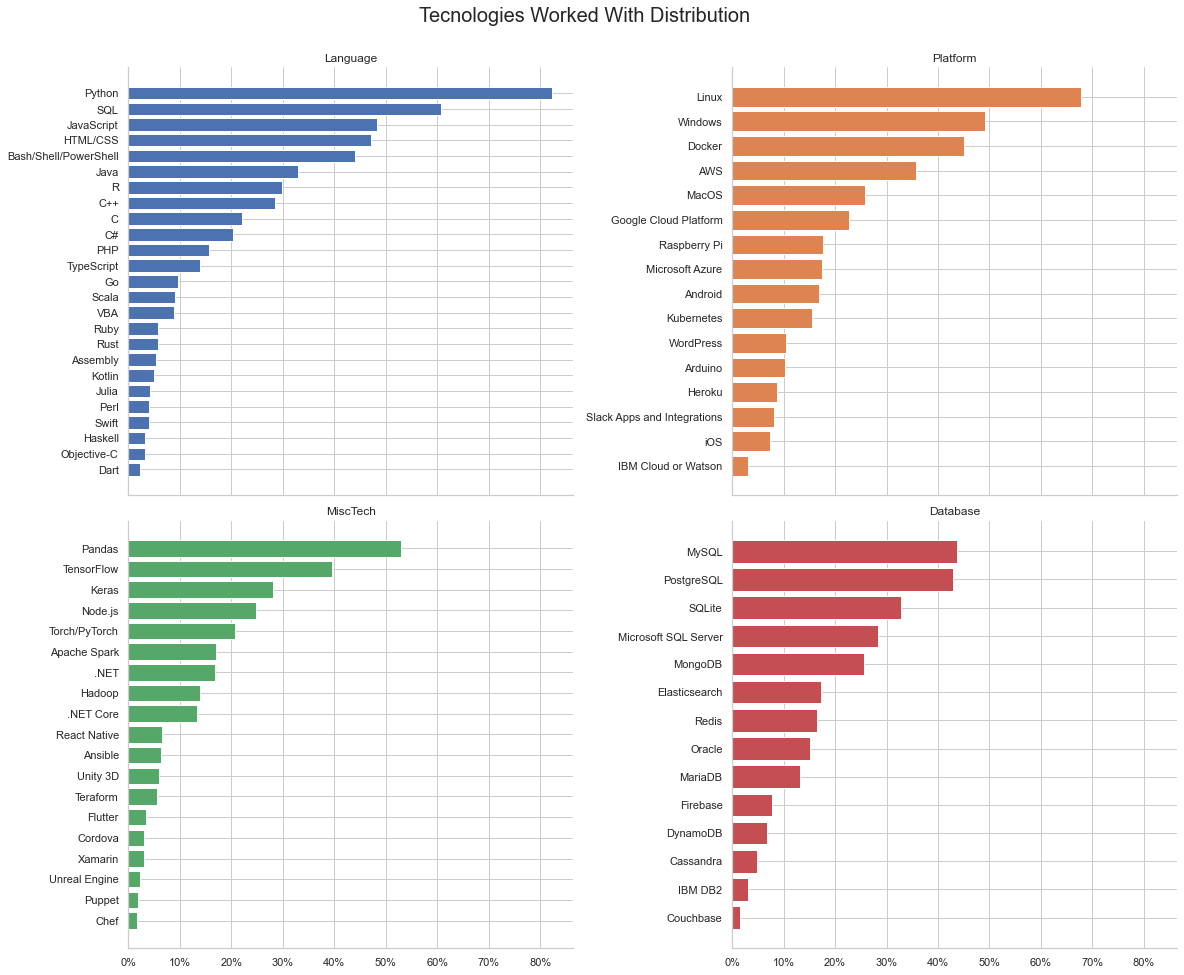

In [27]:
# ploting tech distribution results
plot_dummies_results(tech_dist, True, 'Tecnologies Worked With Distribution')

### 2.3.2 Educational Variables

In [28]:
# getting the educational variables dummies
edu_dummies = dummify_df(edu_df).reindex(y.index)
edu_dummies.shape

(2601, 21)

In [29]:
# creating the distribution of edu options
edu_dist = generate_distributions(edu_dummies, False)
edu_dist.head()

,value,var,option
0,0.002307,UndergradMajor,I never declared a major
1,0.003076,EdLevel,Primary/elementary school
2,0.003845,EdLevel,I never completed any formal education
3,0.004614,UndergradMajor,Fine arts or performing arts (such as graphic ...
4,0.005767,UndergradMajor,Web development or web design


In [30]:
# selecting the option
highlevel_edu = ["Other doctoral degree (Ph.D., Ed.D., etc.)",
                 "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",
                 "Bachelor’s degree (B.A., B.S., B.Eng., etc.)"]
# printing their percentages
display_value(edu_dist, highlevel_edu)

Other doctoral degree (Ph.D., Ed.D., etc.): 15.38%
Master’s degree (M.A., M.S., M.Eng., MBA, etc.): 42.21%
Bachelor’s degree (B.A., B.S., B.Eng., etc.): 32.80%


In [31]:
top3_major = ["Computer science, computer engineering, or software engineering",
              "Mathematics or statistics", "A natural science (such as biology, chemistry, physics, etc.)"]
                
display_value(edu_dist, top3_major)

Computer science, computer engineering, or software engineering: 46.94%
Mathematics or statistics: 12.11%
A natural science (such as biology, chemistry, physics, etc.): 11.42%


The majority of respondents have at least a graduate degree (91.09%), with 40.21% being masters, 32.80% bachelors and 15.38% a doctoral degree. From that being said we can argue that to be a data scientists is important to have a high level of formal education. This is much diffent than we have found for the other developers. Dispite that most developers who graduated in a university declared their major as being Computer science, computer engineering, or software engineering (46.94%). The big diffences is in the second and third most common undergraduate major: Mathematics or statistics (12.11%) and a natural science (suc as biology, chemistry, physics, etc.) (11.42%). Here we don't know exactly wich natural science was declared but if we consider physics we have that both the second and third most common undergraduate major is heavy dependent on mathematical and statistical knowledge, wich alongside coding as some of the most import knowledge for practicing data science.

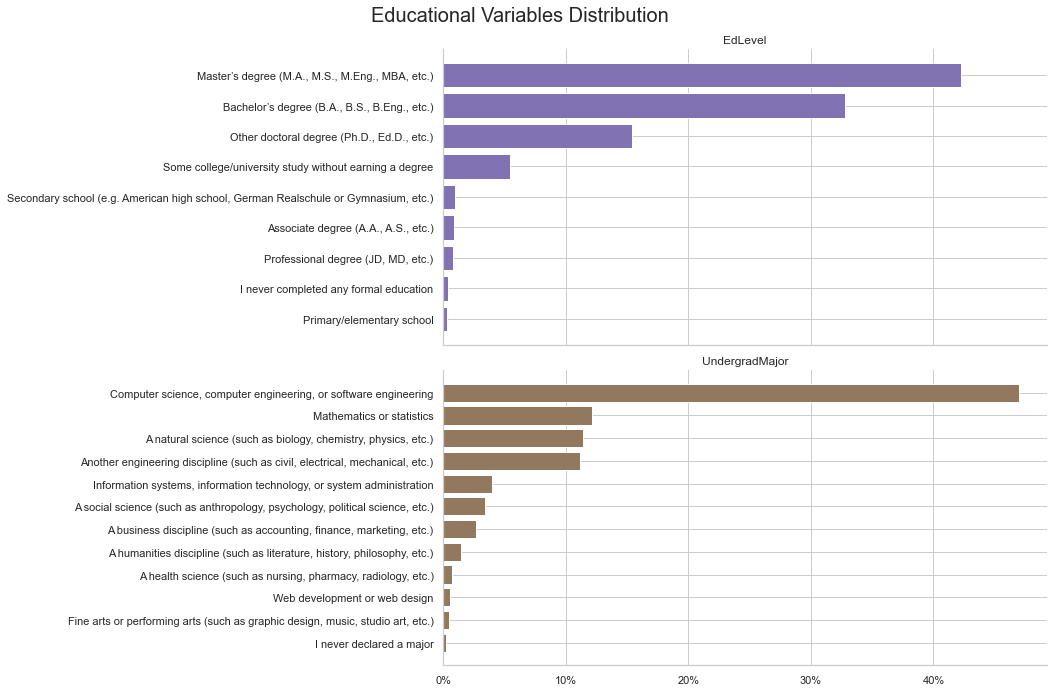

In [32]:
plot_dummies_results(edu_dist, False, 'Educational Variables Distribution')

# 3.0 Measuring the relationship between technological and educationa variables with compensations levels

Now that we already got a overview of our selected variables let's jump into the main focus of this notebook and start to measure the relationship between technological and educational characteristics with compensations levels of data scientists professionals.

To do it we will try three approaches. First, we will apply the Point-Biserial Correlation Coefficient wich will measure the strengh of association between the our tecnological and educational variables and our compensation measures. Then we will model linear relationship of the selected features with the compensation, first by using one simple linear regression model for each feature and then one multiple linear regression model with all the features together.

## 3.1 Point-Biserial Correlation Coefficient

The [Point-biserial correlation coefficient](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) is used when we want to measure the strength of the association between a continuous variable with a dichotomous variable. In our case, each of our dummy’s variables are dichotomous, while our measures of compensations are continuous. By measuring those correlations we can identify wich variable might be good to use in our linear model.

In [33]:
def biserial_corr(y, cat):
    """Compute the point-biserial correlation coefficent as specified in the wikipedia article:
    https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient
    
    We are using the sample correction.
    """
    
    n = y.shape[0]
    mu = np.mean(y)
    sum_sqr_dev = np.sum((y-mu)**2)
    sigma_sample = np.sqrt(sum_sqr_dev/(n-1))
    
    g0_select = cat == 0
    n0 = g0_select.sum()
    mu0 = y[g0_select].mean()
    
    g1_select = cat == 1  
    n1 = g1_select.sum()
    mu1 = y[g1_select].mean()
    
    return   ((mu1 - mu0)/sigma_sample) * np.sqrt(n1 * n0 / (n * (n-1)))

In [34]:
def generate_corr_data(dummies_df, is_tech):
    """Apply the biserial corr in order to generate a data frame of
    correlations. To add variable name and option columns we also 
    use split_var_options function.
    """
    
    # generating correlations data
    corr = [biserial_corr(log_y, dummies_df[col]) for col in dummies_df.columns]
    data = {'value': corr, 'cols': dummies_df.columns}
    df = pd.DataFrame(data)
    
    # adding to the data frame var and option columns,
    # and removing cols columns
    df = split_var_option(df, 'cols', is_tech)
    
    df.sort_values("value", inplace=True)
    
    return df

### 3.1.1 Technological Variables

In [35]:
tech_corr = generate_corr_data(tech_dummies, True)

In [36]:
tech_list = ["Python", "JavaScript", "Bash/Shell/PowerShell", "Scala", "Julia", "SQL", "HTML/CSS"]
display_value(tech_corr, tech_list)

Python: 6.27%
JavaScript: -1.79%
Bash/Shell/PowerShell: 15.43%
Scala: 10.88%
Julia: 8.80%
SQL: 0.59%
HTML/CSS: -7.91%


In [37]:
tech_list = ["MacOS", "AWS", "Linux", "Windows", "Docker", "Kubernetes"]
display_value(tech_corr, tech_list)

MacOS: 14.34%
AWS: 14.52%
Linux: 4.75%
Windows: -3.60%
Docker: 12.92%
Kubernetes: 9.39%


In [38]:
tech_list = ["Pandas", "TensorFlow", "Keras", "Torch/PyTorch", "Teraform", "Apache Spark", "Hadoop"]
display_value(tech_corr, tech_list)

Pandas: 3.07%
TensorFlow: 0.09%
Keras: -3.58%
Torch/PyTorch: 0.23%
Teraform: 9.84%
Apache Spark: 8.41%
Hadoop: 6.45%


In [39]:
tech_list = ["MySQL", "Elasticsearch", "DynamoDB"]
display_value(tech_corr, tech_list)

MySQL: -13.68%
Elasticsearch: 8.72%
DynamoDB: 8.34%


Despite being two of the most popular languages, Python (0.0627) and JavaScrip (-0.0179) have low correlation levels with the log of the compensation. At the other hand command line languages (bash/shell/powershell) (0.1543) have the highest correlation, followed by Scala (0.1088) and Julia (0.088). Might be the case that since a lot of developers know python, this knowledge isn't important to get a good job with higher wages, but in fact is a requirement for the profession. Since we don't have much developers who know Scala and Julia, employers might be willing to pay more for those professionals.  

Considering the platforms technologies, MacOS (0.1434) is the one with the highest correlation, followed by three other technologies associated with the deployment of data science application: AWS (0.1452), Docker ( 0.1292) and Kubernetes (0.0939). We can't mistake association with causation.

As the most positive correlated miscellaneous technology we don't see a technology used directly for data science, but Teraform (0.0984) a technology for infrastructure management. Only than in the second and third place we have two technologies more used for data science projects, Spark (0.0841) and Hadoop (0.0645) two big data technologies. Keras (-0.0358) a technology for deep learning have the second lowest negative correlation.

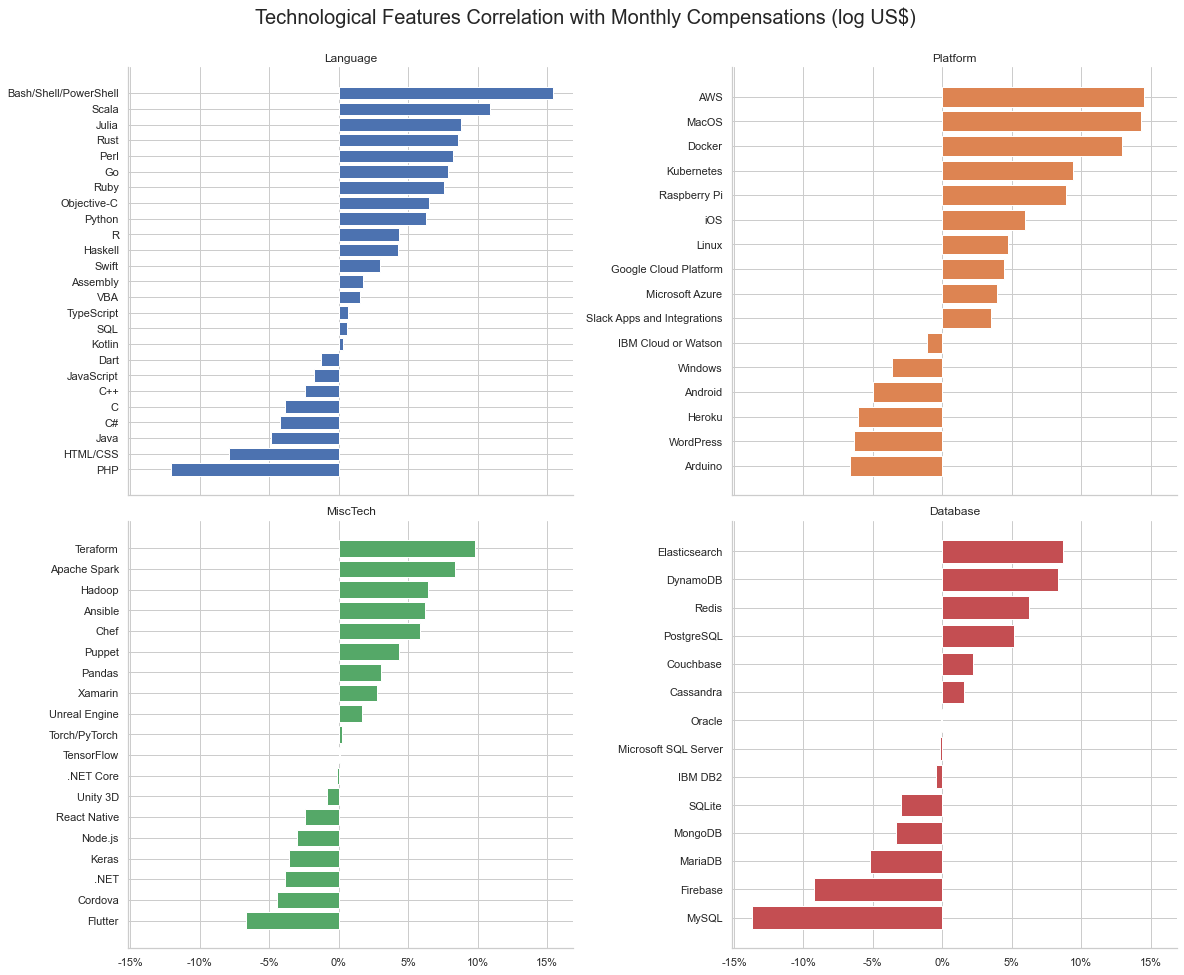

In [40]:
plot_dummies_results(tech_corr, True, 'Technological Features Correlation with Monthly Compensations (log US$)')

### 3.1.2 Educational Variables

In [41]:
edu_corr = generate_corr_data(edu_dummies, False)

In [42]:
edu_corr.sort_values(["var", "value"], ascending=False).set_index(["var","option"]).round(4)['value']

var             option                                                                            
UndergradMajor  A natural science (such as biology, chemistry, physics, etc.)                         0.0936
                A humanities discipline (such as literature, history, philosophy, etc.)               0.0544
                Mathematics or statistics                                                             0.0529
                A social science (such as anthropology, psychology, political science, etc.)          0.0476
                A business discipline (such as accounting, finance, marketing, etc.)                  0.0296
                I never declared a major                                                              0.0073
                Fine arts or performing arts (such as graphic design, music, studio art, etc.)        0.0046
                Another engineering discipline (such as civil, electrical, mechanical, etc.)         -0.0158
                A health scie

Considering the repspondents educational level, other doctoral degree is the one with the highest assocation with the log of compensations (0.1657). At the other end Bachelor’s degree (B.A., B.S., B.Eng., etc.) has the highest negative association (-0.1571).

In the undergraduate majors, we also see some interesting facts. First, all the majors that are more strictly related to information technologies, are negative correlated to compensations. Not only that, but they also have the lowest value of correlation compared to all the other majors. A natural science (such as biology, chemistry, physics, etc.) is the one with highest correlation (0.0936), followed by A humanities discipline (such as literature, history, philosophy, etc.) (0.0544) and Mathematics or statistics (0.0529).

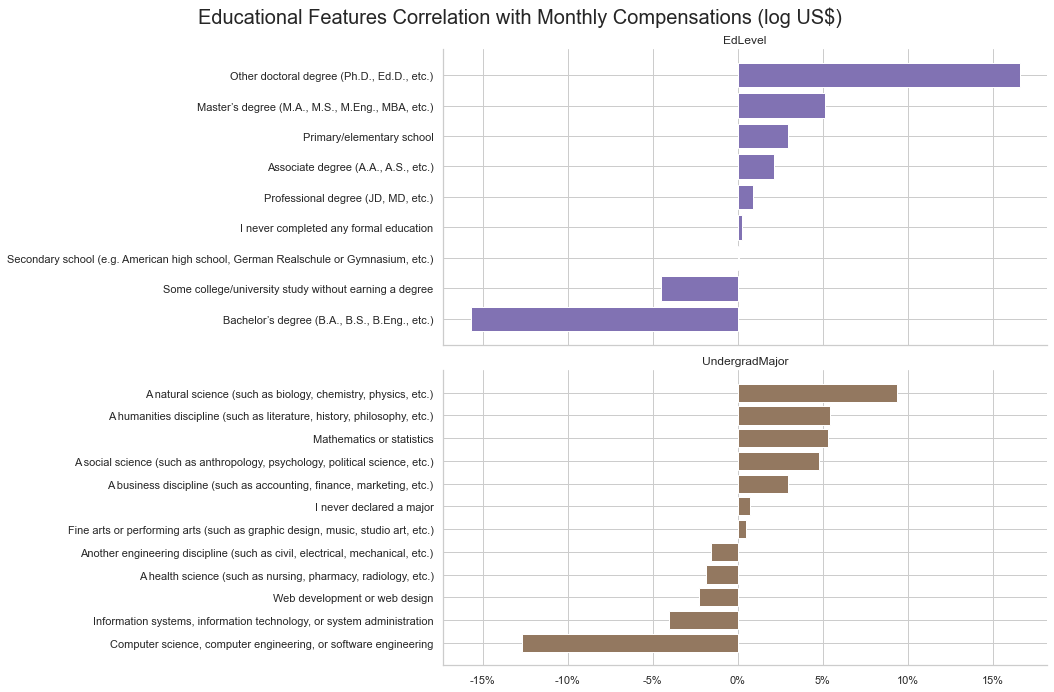

In [43]:
plot_dummies_results(edu_corr, False, 'Educational Features Correlation with Monthly Compensations (log US$)')

## 3.2 Simple Linear Model

With a linear model we can measure the impact of one variable to another. Like how our dependent variable will change if a independent variable changes. In our case, what is the change in the compensation level when data scientists have/don't have a specific feature. Since we are using the compensation in log units, we won't get an absolute change measure, but a relative one. So our the coefficients will represent the percentual change in compensation.

In this section we will compute one simple linear regression model for each dummy 


In our plots we will only display those features whose coefficients are statistically significant at a 5% confidence level.

In [44]:
def regression_coef(y, cat):
    """Run a linear regression model in the form |y = a + b * cat|
    where y is a numerical variable and cat is a binary variable
    returning the coeficient |b| and its p-value.
    """
    
    # turning the series into a data frame
    x = pd.DataFrame(cat)
    # to guarentee that there is no missing observations
    x.fillna(0, inplace=True)
    # adding a intercept column
    x['intercept'] = 1
    # adjusting X observations to match y observations
    x = x.reindex(y.index)
    
    # generating and fitting the model
    lm = sm.OLS(y, x)
    result = lm.fit()
    
    # getting the pvalue and coefficient of the selected category
    pvalue = result.pvalues[cat.name]
    coef = result.params[cat.name]
    
    return coef, pvalue

In [45]:
def generate_coefs_data(dummies_df, is_tech):
    """Apply the regression coef function for each column in dummies_df agaings log_y
    Turn it into a dataframe with values (coefficient values) and pvalues.
    Then add variable with the name of the columns used to generate those values,
    and select only those that are statistically significant at 5%.
    Finally apply split_var_options to get var and options columns and print 
    the number of total features used and those that were statistically significant.
    """
    
    # generating the data from the results of regression_coef function
    coefs = [regression_coef(log_y, dummies_df[col]) for col in dummies_df.columns]
    df = pd.DataFrame(coefs)
    df.columns = ['value', 'pvalue']
    df['cols'] = dummies_df.columns
    
    # selecting statistically significant variables
    df = df.loc[df['pvalue'] < 0.05, ['value', 'cols']].copy()
    
    # generating the var and option columns while removing cols
    df = split_var_option(df, 'cols', is_tech)
    
    df.sort_values('value', inplace=True)
    
    # printing the results
    total_features = dummies_df.shape[1]
    significant_features = df.shape[0]
    print("Total features:", total_features, "\nSignificant features:", significant_features)
    
    return df

### 3.2.1 Tech

In [46]:
tech_coefs = generate_coefs_data(tech_dummies, True)

Total features: 74 
Significant features: 45


Since here we will only be displaying those features that are statistical significant in the determining the log of the compensation levels, some of those features with intermediary values (lower absolute values of correlation) are not being displayed in our plots. Of all 74 features realted to tecnologies tha the respondents had worked with in 2020, only 45 were statisticaly significant at 5%.

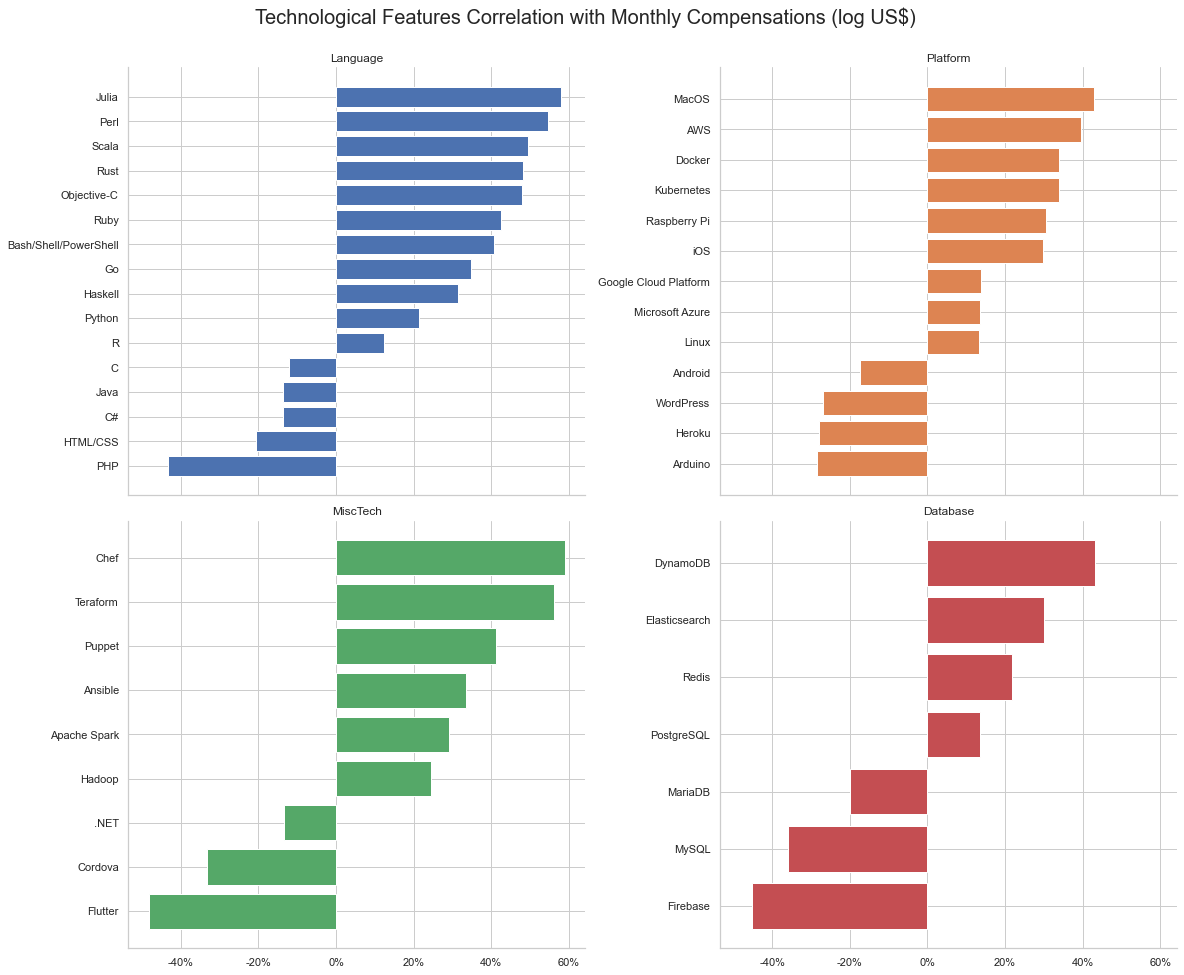

In [47]:
plot_dummies_results(tech_coefs, True, 'Technological Features Correlation with Monthly Compensations (log US$)')

### 3.2.2 Edu

In [48]:
edu_coefs = generate_coefs_data(edu_dummies, False)

Total features: 21 
Significant features: 10


Like what happened in the analysis of the coefficients of the technological features, here, educational features with a intermediary level correlation didn't have a statistically significant coefficient ("Professional degree", "I never declared a major", etc.). Of all of the 21 educational related features only 10 were statisticaly significant at 5% level.

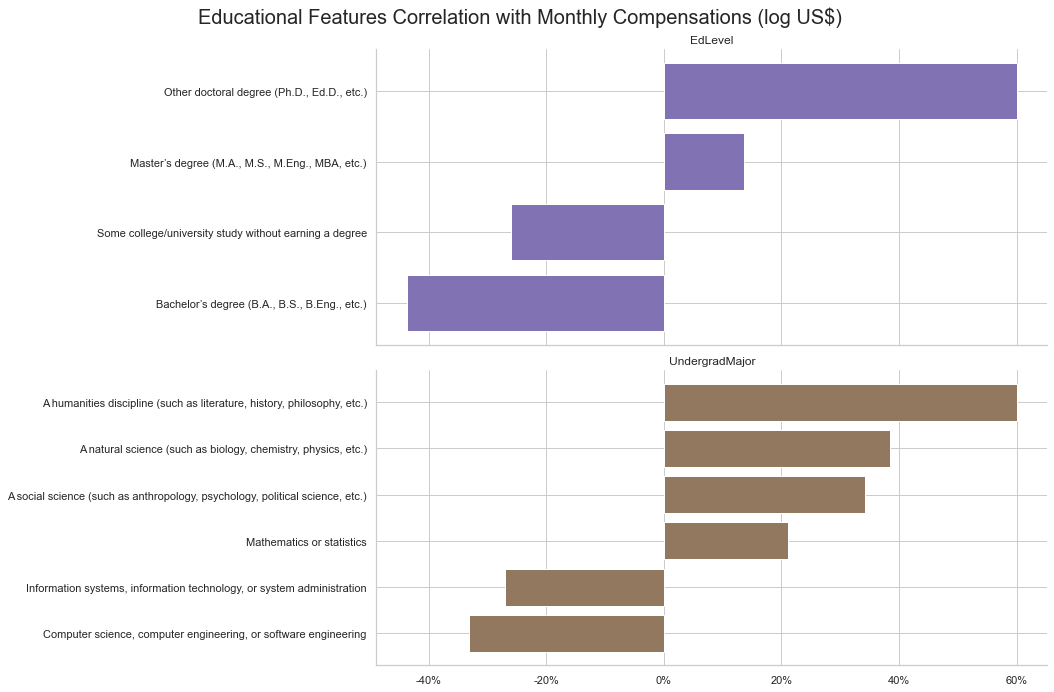

In [49]:
plot_dummies_results(edu_coefs, False, 'Educational Features Correlation with Monthly Compensations (log US$)')

### 3.2.3 Limitations of the simple linear model

A problem with those simple models is that they don't consider the inter relationship between all the variables. That is their correlation with each other and how it effects to their linear coefficient estimates. So our individual coefficients estiamtes might be inflated caused by the correlation between independent variables. This is known by the literature as confunding variables and can generate bias in our estimates.

In order to measure the correlation between independent variables we will be using the [Jaccard Similarity Index](https://en.wikipedia.org/wiki/Jaccard_index). If we have independent variables highly correlated with each other we might have a problem of confunding variables.

In [50]:
# join edu dummies and tech dummies into a
# single dataframe of independent variables for our model
X = edu_dummies.join(tech_dummies)
# to guarentee that we won't have any missing values
X.fillna(0, inplace=True)
# adding a intercept columns
X['intercept'] = 1
# adjusting our independent variables to match our dependents ones.
X = X.reindex(log_y.index)
X.shape

(2601, 96)

In [51]:
def jaccard_index(x, y):
    """Implementation of the jaccard index.
    Compute it from two series of binary values
    """
    x_y = ((x == 1) & (y == 1)).sum()
    return x_y / (x.sum() + y.sum() - x_y)

The mean o jaccard correlation of the top-20 variables (by correlation mean)

In [52]:
jaccard_matrix = X.corr(jaccard_index)

# showing only the top-20 columns with the highest mean values of jaccard.
# we also remove the contribution of the diagonal of the matrix to the means
jaccard_matrix.mean().sort_values(ascending=False).head(20) - 1 / jaccard_matrix.shape[0]

LanguageWorkedWith_Python                                                         0.168046
intercept                                                                         0.166619
PlatformWorkedWith_Linux                                                          0.166549
LanguageWorkedWith_JavaScript                                                     0.166127
LanguageWorkedWith_SQL                                                            0.164726
LanguageWorkedWith_HTML/CSS                                                       0.162726
DatabaseWorkedWith_MySQL                                                          0.156373
PlatformWorkedWith_Docker                                                         0.155105
DatabaseWorkedWith_PostgreSQL                                                     0.149022
LanguageWorkedWith_Bash/Shell/PowerShell                                          0.148696
PlatformWorkedWith_AWS                                                            0.145210

15 variables have at least a correlation higher than 50% with other variables.

In [53]:
((jaccard_matrix > .5).sum() > 1).sum()

15

In [54]:
selected_dummies = (jaccard_matrix > .5).sum() > 1
jaccard_matrix.loc[selected_dummies, selected_dummies]

,LanguageWorkedWith_C#,LanguageWorkedWith_Dart,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,PlatformWorkedWith_Docker,PlatformWorkedWith_Linux,MiscTechWorkedWith_.NET,MiscTechWorkedWith_.NET Core,MiscTechWorkedWith_Flutter,MiscTechWorkedWith_Keras,MiscTechWorkedWith_Pandas,MiscTechWorkedWith_TensorFlow,intercept
LanguageWorkedWith_C#,1.000000,0.055357,0.263499,0.265957,0.178729,0.230455,0.156250,0.167515,0.610649,0.534151,0.080279,0.110818,0.126179,0.148858,0.204152
LanguageWorkedWith_Dart,0.055357,1.000000,0.035484,0.037915,0.023732,0.024390,0.033585,0.027057,0.041929,0.054688,0.557895,0.024580,0.019122,0.027384,0.023068
LanguageWorkedWith_HTML/CSS,0.263499,0.035484,1.000000,0.665323,0.440685,0.495996,0.353107,0.430077,0.220426,0.178813,0.055511,0.218692,0.331458,0.292767,0.470588
LanguageWorkedWith_JavaScript,0.265957,0.037915,0.665323,1.000000,0.457278,0.492884,0.382554,0.446523,0.218300,0.180945,0.057526,0.209501,0.341314,0.295119,0.482122
LanguageWorkedWith_Python,0.178729,0.023732,0.440685,0.457278,1.000000,0.566133,0.468944,0.664676,0.143301,0.116352,0.031959,0.329630,0.627660,0.460581,0.822760
LanguageWorkedWith_SQL,0.230455,0.024390,0.495996,0.492884,0.566133,1.000000,0.376565,0.474614,0.195846,0.160531,0.036070,0.241935,0.445259,0.312846,0.606690
PlatformWorkedWith_Docker,0.156250,0.033585,0.353107,0.382554,0.468944,0.376565,1.000000,0.509521,0.122905,0.121302,0.046550,0.296322,0.393443,0.359926,0.450211
PlatformWorkedWith_Linux,0.167515,0.027057,0.430077,0.446523,0.664676,0.474614,0.509521,1.000000,0.137610,0.114225,0.039326,0.303711,0.483003,0.414090,0.677432
MiscTechWorkedWith_.NET,0.610649,0.041929,0.220426,0.218300,0.143301,0.195846,0.122905,0.137610,1.000000,0.576613,0.069246,0.094569,0.094635,0.118321,0.168012
MiscTechWorkedWith_.NET Core,0.534151,0.054688,0.178813,0.180945,0.116352,0.160531,0.121302,0.114225,0.576613,1.000000,0.090680,0.072709,0.084959,0.097522,0.132641


## 3.3 Multiple Linear Regression Model

To address the confunding bias we will use a multiple linear regression model. All the technical and educational variables will be used together in order to compute our estimations of the log of compensations. Since we are adding a lot of variables together, first we don't reduce the precision of our estimates by incurring in multicolinearity. After removing variables the most contributes to multicolinearity we will then run the final model.

### 3.3.1 Treating multicolinearity 

To address the multicollinearity problem we will introduce a feature selection step by removing features with [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (VIF) above a critical threshold. For this study a threshold of 10 was selected.

In [55]:
def identify_multicolinearity(X, threshold=10):
    """For column in X computes its variance inflation factor and return only.
    those factors from variables that might be causing severe multicolinearity.
    As a rule of thumb a factor above 10 (default threshold) is problematic.
    
    The variance inflation factor is used to quantify the severity of multicolinearity
    in and ols regression analysis. More specificaly, it measures how much the
    variance of coefficient estimates is increased becase of collinearity
    https://en.wikipedia.org/wiki/Variance_inflation_factor
    """
    
    data = [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
    vif = pd.Series(data=data, index=X.columns, name='vif_factor')
    critical_vif = vif[vif > threshold]
    
    return critical_vif

In [56]:
# identifing the features that have factor above 10
identify_multicolinearity(X)

EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)        30.689097
EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)     33.836105
EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)          18.741899
intercept                                                  169.187108
Name: vif_factor, dtype: float64

We identified that three dummies realted to Educational Level have a higher than the threshold level of VIF. Most certainly this happened because we doesn't removed any of the categories from this variable when we got our dummies. Since the respondents could only select one of those features, the intercept could be return as a result of the linear combination of all those dummies. This just didn't happened since some missing values were turned into 0 values. That was the same case for the Undergraduate Majors, but since for this variable there more missing values we didn't got a VIF above 10. If we didn't have any missing values, or had removed all missing obervations, by mantaining all categories from those variables would result in perfect multicolinearity.

To reduce the VIF factor we will first remove one of those features that got VIF above 10. EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.) was selected to be removed. After removing this feature the `identify_multicolinearity`will be ran againg and we will verify if there is any other variable with VIF above 10.

In [57]:
# selcting one of those features to be droped
# removing it from our predictors and than computing again
# the variation inflation factor
droped_features = ['EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)']
X_new = X.drop(columns=droped_features)
identify_multicolinearity(X_new, 10)

intercept    44.096885
Name: vif_factor, dtype: float64

Just by removing 'EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)' we resolved our problem! Now we can use the matrix with the remaining features in our linear model.

In [58]:
# final matrix with 95 features
X_new.shape

(2601, 95)

### 3.3.2 Fitting the model

In [59]:
# fitting the multiple linear model with the selected features.
lm = sm.OLS(log_y, X_new)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       LogConvertedComp   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     7.083
Date:                Mon, 17 May 2021   Prob (F-statistic):           6.21e-75
Time:                        22:14:08   Log-Likelihood:                -4078.2
No. Observations:                2601   AIC:                             8346.
Df Residuals:                    2506   BIC:                             8903.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
EdLevel_Associate degree (A.A., A.S., etc.)                                                       0.4391      0.257      1.709      0.088      -0.065       0.943
EdLevel_I never completed any formal education                                                    0.1182      0.409      0.289      0.772      -0.683       0.919
EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                           0.3231      0.056      5.798      0.000       0.214       0.432
EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)                                                0.7137      0.079      9.090      0.000       0.560       0.868
EdLevel_Primary/elementary school                                                                 0.2135      0.465      0.459      0.646      -0.699       1.126
EdLevel_Professional degree (JD, MD, etc.)                                                        0.5260      0.268      1.961      0.050     5.8e-05       1.052
EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)       -0.0904      0.274     -0.330      0.741      -0.627       0.446
EdLevel_Some college/university study without earning a degree                                    0.0625      0.112      0.557      0.577      -0.157       0.283
UndergradMajor_A business discipline (such as accounting, finance, marketing, etc.)              -0.0059      0.197     -0.030      0.976      -0.392       0.380
UndergradMajor_A health science (such as nursing, pharmacy, radiology, etc.)                     -0.6129      0.309     -1.983      0.047      -1.219      -0.007
UndergradMajor_A humanities discipline (such as literature, history, philosophy, etc.)            0.0921      0.239      0.385      0.700      -0.377       0.562
UndergradMajor_A natural science (such as biology, chemistry, physics, etc.)                     -0.1666      0.151     -1.106      0.269      -0.462       0.129
UndergradMajor_A social science (such as anthropology, psychology, political science, etc.)      -0.0669      0.185     -0.362      0.717      -0.429       0.295
UndergradMajor_Another engineering discipline (such as civil, electrical, mechanical, etc.)      -0.3434      0.151     -2.268      0.023      -0.640      -0.047
UndergradMajor_Computer science, computer engineering, or software engineering                   -0.4702      0.139     -3.394      0.001      -0.742      -0.199
UndergradMajor_Fine arts or performing arts (such as graphic design, music, studio art, etc.)    -0.2308      0.371     -0.622      0.534      -0.958       0.496
Under

In [60]:
# selecting desired params
selected_features = result.params.index.str.contains('WorkedWith|UndergradMajor|EdLevel')
# dataframe with values of pvalues and coefficients values for all the selected params 
selected_coefs = pd.DataFrame(data=np.array([result.params, result.pvalues]).T,
                           columns=['coef', 'pvalues'],
                           index=result.params.index)[selected_features]

# removing not significant variables
significant_coefs = selected_coefs[selected_coefs['pvalues'] <= 0.05].sort_values('coef').reset_index()
# renaming the index
significant_coefs.rename(columns={'index': 'dummy'}, inplace=True)

# splting the dummy name into variable and option
significant_coefs[['variable', 'option']] = significant_coefs['dummy'].str.split('_', expand=True)
significant_coefs['variable'] = significant_coefs['variable'].str.replace('WorkedWith', '')
significant_coefs['variable'] = pd.Categorical(significant_coefs['variable'],
                                               categories=tech_types + edu_vars, ordered=True)

In [61]:
# number of features comparison
total_features = X_new.shape[1] - 1 # minus one - intercept
significant_features = significant_coefs.shape[0]
print("Total features:", total_features, "\nSignificant features:", significant_features)

Total features: 94 
Significant features: 27


In [62]:
significant_coefs.sort_values(['variable', 'coef']).set_index(['variable', 'option'])['coef'].mul(100).round(2)

variable        option                                                                      
Language        PHP                                                                            -20.97
                HTML/CSS                                                                       -15.87
                Bash/Shell/PowerShell                                                           25.35
                Scala                                                                           26.18
                Perl                                                                            27.10
                Objective-C                                                                     33.06
Platform        Arduino                                                                        -37.94
                Heroku                                                                         -22.30
                Docker                                                                     

When we consider all the features simultaneously, we have a even more reduced number of statistically significant features.Of the 94 selected features, only 27 were statisticaly significant at 5%. That happens because some of those previously significant identified features might have been significant only because they were correlated to another variable that was truly correlated with the log of the compensations.

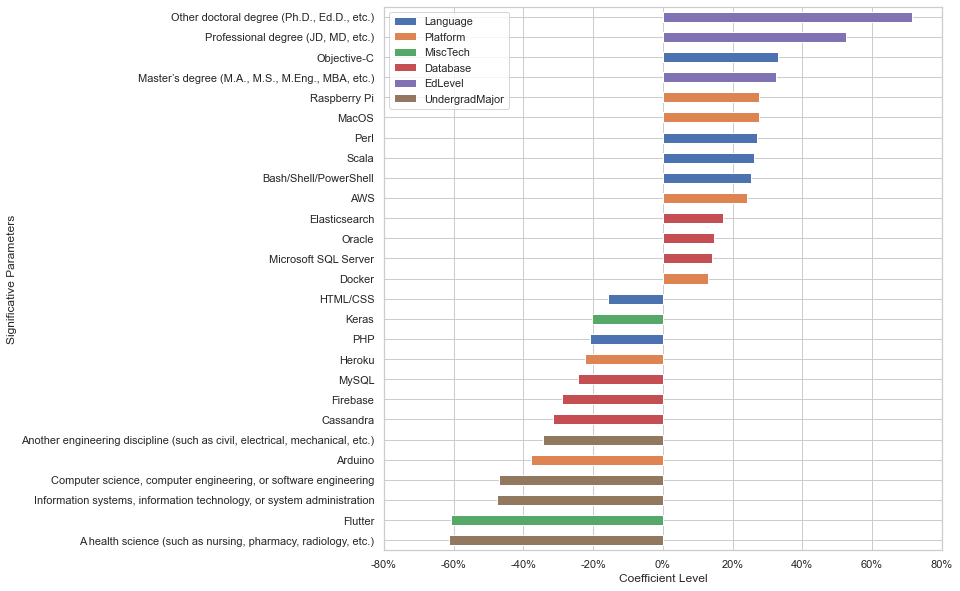

In [63]:
# ploting only the significant coefficients
# here we are using the same color scheme as used in the other plots
ax = (significant_coefs.pivot(index='option', columns='variable', values='coef').
      reindex(significant_coefs['option']).
      plot(kind='barh', stacked=True, figsize=(10,10)))
ax.set_xlim(-.8, .8)
ax.xaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
plt.xlabel('Coefficient Level')
plt.ylabel('Significative Parameters')
#plt.title('Coefficient Level of Significative Paramerers Related to the Log of Monthly Compensations')
plt.legend(title='')
plt.savefig('figs/tech_edu_coef.png', bbox_inches='tight', dpi=300)
plt.show()

In [64]:
significant_coefs.set_index("option").tail(5)['coef'].mul(100).round(2)

option
Raspberry Pi                                       27.49
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)    32.31
Objective-C                                        33.06
Professional degree (JD, MD, etc.)                 52.60
Other doctoral degree (Ph.D., Ed.D., etc.)         71.37
Name: coef, dtype: float64

I believe the main point in this analysis is that it is important to study, to have a higher level of formal education. More important than the language that you use, or any other specific technology that you work with. The most important thing is to study. Perl, Scala and Objective-C are also important. Of the five features with the highest positive impact on the compensations levels, three of them are relative to the respondents education level. Having a doctoral degree can increase data scientists compensation level by 71.37%. A Professional degree by 52.60% and Master's degree by 32.31%.

Our final model is a improvement over the initial linear model, but there might have other confunding variables that we didn't used and might be introducing some bias into our estimates. To further improve the accuracy of our model we would need to broad the scope of our analysis and try to consider other variables into our model. 